# Question 1: What are the most popular Airbnb locations in Berlin?
The first question around the Airbnb Berlin data set is about identifying __areas of the city that are more popular than others__. The results may work as __guidance__ for people who are interested in __renting out apartments__ either privately or professionally.

The __five steps__ involved in this notebook are as follows:
* 1 - Load libraries
* 2 - Import & understand data
* 3 - Pre-process data
* 4 - Model data
* 5 - Analyze data & evaluate results

## 1 - Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2 - Import & Understand Data

In [2]:
# Import listings data (Source: http://insideairbnb.com/get-the-data.html)
df_listings = pd.read_csv('../data/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20180912025131,2018-09-12,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,6 weeks ago,t,5,34,64,154,2018-09-12,109,2016-04-11,2018-09-08,92.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,3.69


### 2.1 - Overview
There are multiple columns in the data set that appear to be very useful for answering the question posed at the beginning of this notebook. However, before comparing different areas of Berlin with each other it's important to __define the term "popularity"__. In particular, the popularity of an area is influenced by __two main features__, whereas an increase in each of them increases popularity and vice versa. These feature are:

* The __number of apartments__
* The __occupancy of apartments__

__Attributes__ in the Airbnb data set that can be used to __estimate__ the popularity of different areas are:
* neighbourhood_group_cleansed
* minimum_nights, reviews_per_month

## 3 - Pre-Process Data

Before starting to model the data it's important to pay close attention to the columns that need to be used and pre-process them or the data set where necessary.

### 3.1 - Property Types

In [3]:
# Check distriution of property types
property_count = df_listings["property_type"].value_counts().sum()
print((df_listings["property_type"].value_counts().sort_values(ascending=False) / property_count).head())

# Number of unique property types
print("\nThere are {} unique property types within the data set.".format(len(df_listings["property_type"].unique())))

Apartment             0.900097
Condominium           0.026715
Loft                  0.018740
House                 0.018120
Serviced apartment    0.008462
Name: property_type, dtype: float64

There are 33 unique property types within the data set.


The __22,572 Airbnb listings__ in Berlin can be mapped to __33 different property types__, with __90% of all property types actually being apartments__. As I am mainly interested in apartments I am going to remove all listing with property types other than "Apartment".

In [4]:
# Keep only apartments in analysis
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2255 records were removed from the Airbnb Berlin listings data frame.


Now that I've removed all property types other than apartments, it's time to __check for missing values__ in the columns that need to used for a popularity comparison of areas.

### 3.2 - Missing Values

In [5]:
# Check for missing values
df_listings[["neighbourhood_group_cleansed","minimum_nights","reviews_per_month"]].isnull().sum()

neighbourhood_group_cleansed       0
minimum_nights                     0
reviews_per_month               3584
dtype: int64

It looks like the column __"reviews_per_month"__ has __missing values__. If a listing has never received any reviews before than I should probably set the value for "reviews_per_month" to 0.

In [6]:
# Impute missing values
df_listings["reviews_per_month"] = df_listings["reviews_per_month"].fillna(0)

# Check for missing values
df_listings[["reviews_per_month"]].isnull().sum()

reviews_per_month    0
dtype: int64

The column "neighbourhood_group_cleansed" stores information on the area a listing is located in. Let's look at it's values:

### 3.3 - Neighbourhoods

In [7]:
# Check distriution of neighbourhood groups
hood_count = df_listings["neighbourhood_group_cleansed"].value_counts().sum()
print((df_listings["neighbourhood_group_cleansed"].value_counts().sort_values(ascending=False) / hood_count))

# Number of unique neighbourhood groups
print("\nThere are {} unique neighbourhood groups types within the data set.".format(len(df_listings["neighbourhood_group_cleansed"].unique())))

Friedrichshain-Kreuzberg    0.252252
Mitte                       0.203918
Neukölln                    0.163853
Pankow                      0.158045
Charlottenburg-Wilm.        0.069055
Tempelhof - Schöneberg      0.068120
Lichtenberg                 0.028105
Treptow - Köpenick          0.023527
Steglitz - Zehlendorf       0.016489
Reinickendorf               0.009992
Spandau                     0.003741
Marzahn - Hellersdorf       0.002904
Name: neighbourhood_group_cleansed, dtype: float64

There are 12 unique neighbourhood groups types within the data set.


The __22,572 Airbnb listings__ are located in __12 different neighbourhood groups, with__ 23% of all listings actually being in __Friedrichshain-Kreuzberg__. I'm not too happy with the text formatting of values so I'm going to adjust it slighty.

In [8]:
# Adjust values of "neighbourhood_group_cleansed"
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace(" ", "")

## 4 - Model Data

The analysis of an area's popularity on Airbnb is focused around __two main features__, namely the number of apartments in a particular area as well as the occupancy of individual apartments. Unfortunately, the data set doesn't provide all this information for us ready to use. Thus, I need to come up with __a way to model the data__.

As the number of apartments in each neighbourhood can easily be calculated the modeling steps is focused on occupancy alone.

### 4.1 - Occupancy

The occupancy of an apartment is defined by two things: the __duration__ and the __number of bookings__. If I assume that the a booking's duration is equal to the minimum number of nights per booking on average then "__minimum_nights__" is the column to use as proxy for duration. Also, if I assume that most of the people who booked an apartment leave a review I can use the column "__reviews_per_month__" as proxy for the number of bookings. However, I'm going to cap the number of reviews per month based on the __maximum number of bookings__ per month. This maximum does not only depend on the booking duration and number of bookings, but also on the maximum number of days a booking is available for bookings. As many listings have a future availability of 0 days - maybe because they are already fully booked - I assume they can in general be booked for a full months i.e. 30.42 days.

In [9]:
# Define adjusted proxy for number of bookings per months
df_listings["max_bookings_per_month"] = (30.42 / df_listings["minimum_nights"]).fillna(0)
df_listings["bookings_per_month"] = df_listings[["max_bookings_per_month","reviews_per_month"]].min(axis=1)
df_listings = df_listings.drop("max_bookings_per_month", axis=1)

df_listings["bookings_per_month"].describe()

count    20317.000000
mean         0.885989
std          1.337913
min          0.000000
25%          0.060000
50%          0.330000
75%          1.080000
max         14.790000
Name: bookings_per_month, dtype: float64

Based on the previously adjusted booking frequency we can now calculate the occupancy. This relies on the assumption that each booking spans for a minimum/maximum period equal to the number of minimum nights.

In [10]:
# Calculate the monthly occupancy rate for each listing
df_listings["occupancy_rate"] = (df_listings["bookings_per_month"] * df_listings["minimum_nights"] / 30.42).fillna(0)
df_listings["occupancy_rate"].describe()

count    20317.000000
mean         0.091688
std          0.160096
min          0.000000
25%          0.005260
50%          0.032873
75%          0.106509
max          1.000000
Name: occupancy_rate, dtype: float64

## 5 - Analyze Data & Evaluate Results

Before looking at the popularity of different areas I want to __look at the two features__ that I use to define it alone.

### 5.1 - Number of Apartments

In [11]:
# Number of listings / neighbourhood group
hood_count = df_listings[["neighbourhood_group_cleansed","id"]]
hood_count = hood_count.groupby("neighbourhood_group_cleansed", as_index=False).agg("count")
hood_count.columns = ["neighbourhood_group", "num_listings"]
hood_count.head()

,neighbourhood_group,num_listings
0,Charlottenburg-Wilmersdorf,1403
1,Friedrichshain-Kreuzberg,5125
2,Lichtenberg,571
3,Marzahn-Hellersdorf,59
4,Mitte,4143


In [12]:
# Average listings count / neighbourhood
hood_count["num_listings"].mean()

1693.0833333333333

On average there are __1,693 listings located in each of them__. However, neighbourhood groups with larger areas (measured in km2) tend to have more Airbnb listings and vice versa. Thus, I need to __account for the size of the area of a neighbourhood group__ when making comparisons on the number of listings.

In [13]:
# Data frame with area in square kilometre / neighbourhood groups
# Source: https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Ortsteile_Berlins
hood_names = ['Pankow','Tempelhof-Schöneberg','Friedrichshain-Kreuzberg','Neukölln','Mitte','Charlottenburg-Wilmersdorf',
              'Treptow-Köpenick','Lichtenberg','Reinickendorf','Steglitz-Zehlendorf','Marzahn-Hellersdorf','Spandau']
hood_size = [103.01,53.09,20.16,44.93,39.47,103.01,168.42,52.29,89.46,102.50,61.74,91.91]
hood_area = pd.DataFrame({"neighbourhood_group": hood_names, "area_km2": hood_size})
hood_area = hood_area.sort_values("neighbourhood_group").reset_index(drop=True)

In [14]:
# Add listing density to neighbourhood counts
hood_count["num_listings_per_km2"] = hood_count["num_listings"] / hood_area["area_km2"]

Let's __compare__ the two calculated values: __number of listings__ vs. __number of listings per square kilometre__.

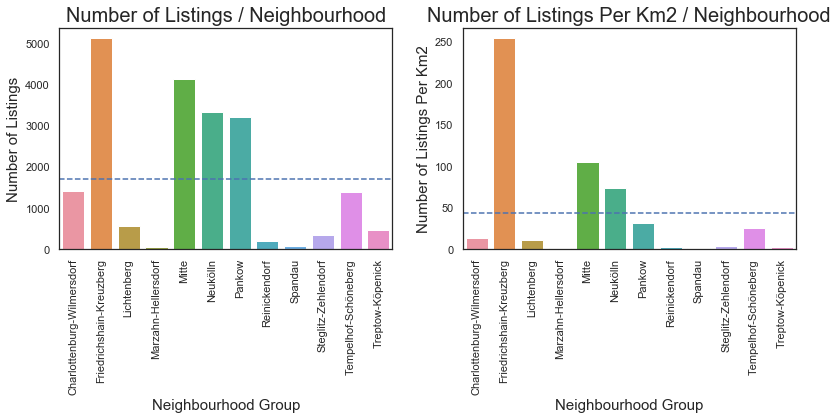

In [19]:
# Plot comparison
fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.set(style = "white")
sns.barplot(x="neighbourhood_group", y="num_listings", data=hood_count, ax = ax[0])
sns.barplot(x="neighbourhood_group", y="num_listings_per_km2", data=hood_count, ax = ax[1])

# Format plot
ax[0].set_xticklabels(hood_count["neighbourhood_group"].values, rotation=90)
ax[0].set_ylabel("Number of Listings", fontsize=15)
ax[0].set_xlabel("Neighbourhood Group", fontsize=15)
ax[0].set_title("Number of Listings / Neighbourhood", fontsize=20)
ax[1].set_xticklabels(hood_count["neighbourhood_group"].values, rotation=90)
ax[1].set_ylabel("Number of Listings Per Km2", fontsize=15)
ax[1].set_xlabel("Neighbourhood Group", fontsize=15)
ax[1].set_title("Number of Listings Per Km2 / Neighbourhood", fontsize=20)
plt.tight_layout()

# Add mean as reference line
ax[0].axhline(hood_count["num_listings"].mean(), ls='--');
ax[1].axhline(hood_count["num_listings_per_km2"].mean(), ls='--');

The __highest density__ of Airbnb apartments can be observed for __Friedrichshain-Kreuzberg__ with 254.22 listings per square kilometre followed by __Mitte__ (104.97) and __Neukölln__ (74.10). Especially when looking at Tempelhof-Schöneberg before and after the adjustment one can observe how it's relevance compared to Charlottenburg-Wilmersdorf as well as Pankow has largely increased. Pankow's listing density is now not even greater than the mean anymore.

### 5.2 - Occupancy

Now, let's look at the __occupancy rate__ of Airbnb listings.

In [20]:
# Create data frame with occupancy rate and listing density for each neighbourhood
# Grouping functions
f = {"id":["count"], "occupancy_rate":["mean"]}

# Grouping data
hood_occupancy = df_listings[["neighbourhood_group_cleansed","id","occupancy_rate"]]
hood_occupancy = hood_occupancy.groupby("neighbourhood_group_cleansed", as_index=False).agg(f)
hood_occupancy.columns = ["neighbourhood_group", "num_listings", "occupancy_rate"]
hood_occupancy = hood_occupancy.sort_values("neighbourhood_group")

# Calculate density
hood_occupancy["area_km2"] = hood_area["area_km2"]
hood_occupancy["listings_per_km2"] = hood_occupancy["num_listings"] / hood_occupancy["area_km2"]

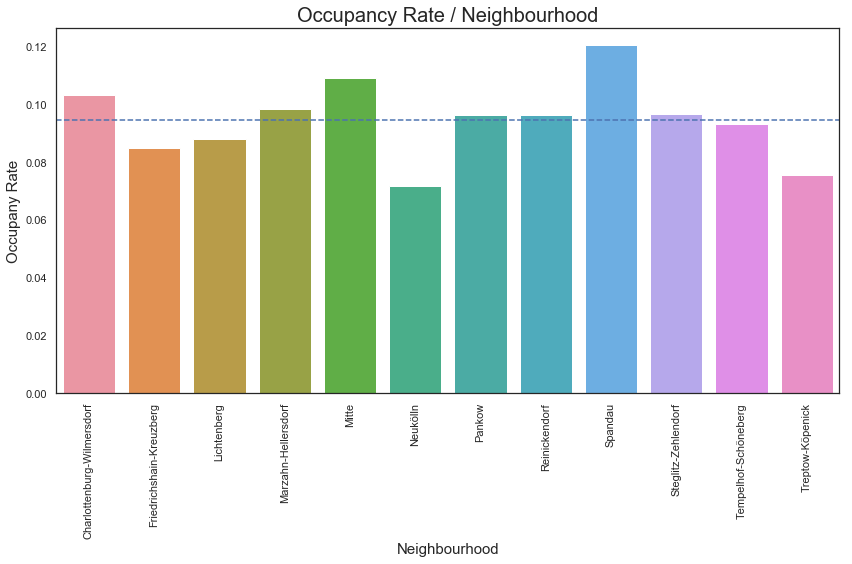

In [21]:
# Plot occupancy rate / neihbourhood group
plt.subplots(figsize=(12,8))
sns.set(style="white")
ax = sns.barplot(x="neighbourhood_group", y="occupancy_rate", data=hood_occupancy)
plt.xticks(rotation=90);
plt.title("Occupancy Rate / Neighbourhood", fontsize=20)
plt.ylabel("Occupany Rate", fontsize=15)
plt.xlabel("Neighbourhood", fontsize=15)
plt.tight_layout()

# Add median as reference line
ax.axhline(hood_occupancy ["occupancy_rate"].mean(), ls='--');

The occupancy rate is highest for __Spandau__  with listing being booked for __12.05%__ of the days in a month on average. It's followed by __Mitte with 10.06%__ and __Charlottenburg-Wilmersdorf with 10.34%__. This is a first indication that areas with a high number of listings may not necessarily benefit from a high occupancy and vice versa.

### 5.3 - Popularity

Now, when combining listing density and occupancy rate we're able to compare Berlin neighbourhood groups regarding their __popularity on Airbnb__.

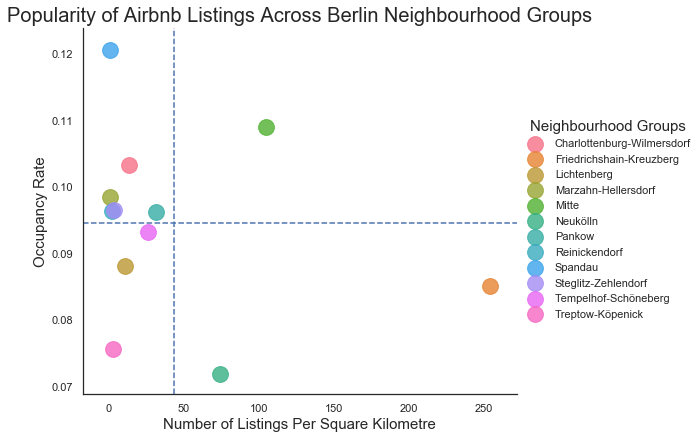

In [22]:
# Plot occupancy vs. listing count per square kilometre for neighbourhood groups
sns.set(style="white")
p = sns.lmplot("listings_per_km2", "occupancy_rate", data=hood_occupancy,
               hue="neighbourhood_group", fit_reg=False,
               height=6, aspect=1.2, scatter_kws={"s": 250})

# Add mean as reference line
plt.axhline(hood_occupancy["occupancy_rate"].mean(), ls='--');
plt.axvline(hood_occupancy["listings_per_km2"].mean(), ls='--');

# Set labels
plt.title("Popularity of Airbnb Listings Across Berlin Neighbourhood Groups", fontsize=20)
plt.ylabel("Occupancy Rate", fontsize=15)
plt.xlabel("Number of Listings Per Square Kilometre", fontsize=15)
p._legend.set_title("Neighbourhood Groups")
plt.setp(p._legend.get_title(), fontsize=15);

The graph above shows how both listing density and occupancy rate are related to each other. Considering both variables now it appears that __Mitte__ is the most popular neighbourhood group of Berlin on Airbnb. It's the only neighbourhood group showing both listings density and occupancy rate being above average. Eventhough a higher listing density can easily result in higher competition between Airbnb home owners, thus leading to lower occupancy rates on average. Nonetheless, __Mitte__ still seems to be able to perform on both scales.